# 1 - Environment Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn 
import pandas as pd
import shutil

# 2 - Data Loading and Preprocessing

- Defining Image Transforms

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

- Importing Data

In [3]:
import os

images_directory = os.path.join("archive", "train")  # Original images are here
labels_directory = os.path.join("archive", "training_set.csv")  # CSV file with labels
labeled_directory = os.path.join("archive", "labeled")  # New folder for labeled images

# Load the csv file
labels = pd.read_csv(labels_directory)
print(labels.head(3))


      filename             label
0  Image_1.jpg  SOUTHERN DOGFACE
1  Image_2.jpg            ADONIS
2  Image_3.jpg    BROWN SIPROETA


- Associating Images with Their Labels and Organizing Them into a New Directory

In [4]:
# Create the new 'labeled' directory if it doesn't exist
os.makedirs(labeled_directory, exist_ok=True)

for index, row in labels.iterrows():
    # Create a folder for each label inside the 'labeled' directory
    folder_path = os.path.join(labeled_directory, row['label'])  # New folder path in 'labeled'
    os.makedirs(folder_path, exist_ok=True)
    # Copy the image from 'train' to the appropriate labeled folder in 'labeled'
    source_path = os.path.join(images_directory, row['filename'])  # Original image path
    destination_path = os.path.join(folder_path, row['filename'])  # Destination path in labeled folder
    shutil.copy(source_path, destination_path)

- Splitting the Data

In [5]:
import numpy as np

# Import the labeled data
data_dir = 'archive/labeled/'
dataset = ImageFolder(root=data_dir, transform=transform)

# Define the size split
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Split the dataset into train and test sets
train_data, test_data = random_split(dataset, [train_size, test_size])

# DataLoader for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Output dataset sizes
print(f"Train set: {len(train_data)}, Test set: {len(test_data)}")


Train set: 5199, Test set: 1300


# 2 - CNN Model Construction

In [6]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
num_classes = len(dataset.classes)
model = SimpleCNN(num_classes)

# 3 - Model Training

- Initialising the model

In [7]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)


- Training and evaluation and Saving the best model

In [8]:
# Initialize the best loss and best model weights
best_loss = float('inf')  # Start with a very large loss value
best_model_wts = None  # Variable to store the best model weights

num_epochs = 20 

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

        # Calculate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Check if the current loss is the best loss and save the model if it is
    if epoch_loss < best_loss:
        best_loss = epoch_loss  # Update the best loss
        best_model_wts = model.state_dict()  # Save the model weights of the best model

# After training, load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model on disk
torch.save(model.state_dict(), 'best_model.pth')  # Save the best model weights
print("Best model saved as 'best_model.pth'")


Epoch [1/20], Loss: 4.0594, Accuracy: 5.10%
Epoch [2/20], Loss: 2.9274, Accuracy: 25.14%
Epoch [3/20], Loss: 1.8895, Accuracy: 49.01%
Epoch [4/20], Loss: 0.8420, Accuracy: 76.11%
Epoch [5/20], Loss: 0.2134, Accuracy: 93.96%
Epoch [6/20], Loss: 0.0592, Accuracy: 98.50%
Epoch [7/20], Loss: 0.0164, Accuracy: 99.63%
Epoch [8/20], Loss: 0.0095, Accuracy: 99.83%
Epoch [9/20], Loss: 0.0249, Accuracy: 99.58%
Epoch [10/20], Loss: 0.0206, Accuracy: 99.52%
Epoch [11/20], Loss: 0.0453, Accuracy: 99.02%
Epoch [12/20], Loss: 0.0743, Accuracy: 98.12%
Epoch [13/20], Loss: 0.0572, Accuracy: 98.40%
Epoch [14/20], Loss: 0.0675, Accuracy: 98.21%
Epoch [15/20], Loss: 0.0357, Accuracy: 99.37%
Epoch [16/20], Loss: 0.0026, Accuracy: 99.98%
Epoch [17/20], Loss: 0.0003, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0002, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0001, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0001, Accuracy: 100.00%
Best model saved as 'best_model.pth'


# 4 - Model Evaluation

- Testing the Model and printing accuracy

In [11]:
model.load_state_dict(torch.load('best_model.pth'))

# Define the number of samples to evaluate (for example, 10% of the test data)
num_samples_to_test = len(test_loader.dataset)

# Disable gradient computation during evaluation
with torch.no_grad():
    test_loss = 0.0  # Initialize test_loss
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        # Break the loop if we've evaluated the specified number of samples
        if i * len(images) >= num_samples_to_test:
            break

        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Accumulate test loss
        test_loss += loss.item()

        # Calculate predictions and accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and display average test loss and accuracy
test_loss /= (i + 1)  # Calculate average loss based on the number of batches evaluated
test_accuracy = 100 * correct / total

# Print evaluation results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Check for overfitting (if training accuracy is significantly higher than testing accuracy)
if epoch_accuracy > test_accuracy + 5:  # If training accuracy is much better than testing accuracy
    print(" Overfitting detected! Consider adding dropout or data augmentation.")

C:\Users\zakaria boukeffa\AppData\Local\Temp\ipykernel_10168\3794896242.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'

Test Loss: 0.7146, Test Accuracy: 90.46%
 Overfitting detected! Consider adding dropout or data augmentation.


- Display some Test Results

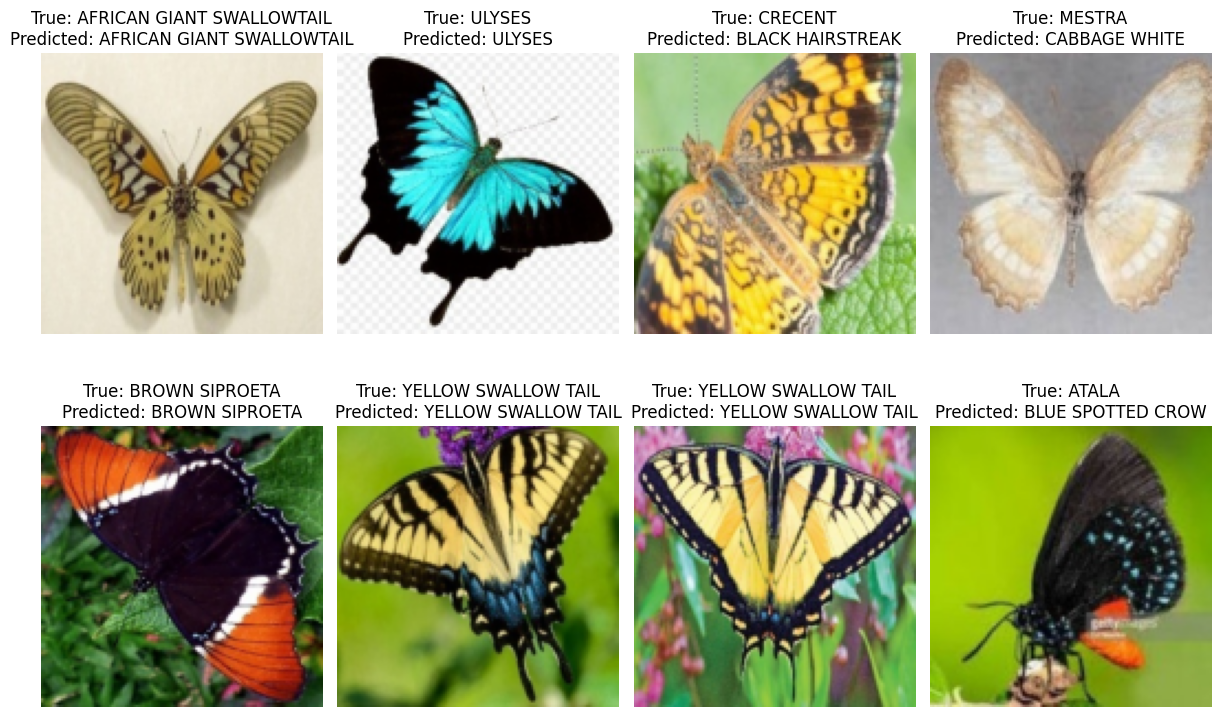

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move data to device
images, labels = images.to(device), labels.to(device)

# Get predictions from the model
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Display a few images with predictions
fig = plt.figure(figsize=(12, 8))
for idx in range(8):  # Display first 8 images
    ax = fig.add_subplot(2, 4, idx+1)
    ax.imshow(images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize and convert to numpy
    ax.set_title(f"True: {dataset.classes[labels[idx]]}\nPredicted: {dataset.classes[predicted[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# 5 - Saving and Conclusion

- Saving the model: Already saved during the training part

- Extra evaluation and suggestions

In [ ]:
# Vérification de l'overfitting
#  Suggestions for Improvement
print("\n🔹 Suggestions for improvement:")
print("- Augment the dataset (Data Augmentation) for more diverse training data.")
print("- Add Dropout layers to prevent overfitting.")
print("- Test other CNN architectures like ResNet, VGG, etc.")
print("- Tune the learning rate and other hyperparameters.")



🔹 Suggestions for improvement:
- Augment the dataset (Data Augmentation) for more diverse training data.
- Add Dropout layers to prevent overfitting.
- Test other CNN architectures like ResNet, VGG, etc.
- Tune the learning rate and other hyperparameters.
